# Baseline - XGBoost

In [1]:
import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split
import datetime
import glob

In [2]:
data_drive = r'G:/'

## 1. Assemble Data into a csv

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

rws_files_paths = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files_paths.sort()
rws_files = list(map(os.path.basename, rws_files_paths))

In [5]:
def assemble_instances(files, file_paths, temp_path):
    data = []
    instances_list = []

    for i in range(0, len(files)-15):
        regnie_srcs =  []
        temp_srcs = []
        for l in range(1,13):
            regnie_srcs.append(rio.open(file_paths[i+l]))
        for l in (1, 5, 9):
            #Monatsauswahl noch tricky
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ files[i+l][9:11]+'_'+files[i+l][4:8]+'_01.tif'))
        stations = gw_weekly.loc[ files[i][4:14] , : ].dropna().index.tolist()
        for s in stations:
            d = np.array([])
            instance_desc = []
            instance_desc.append(s)
            east = stammdaten.loc[s]['OSTWERT']
            north = stammdaten.loc[s]['NORDWERT']
            row, col = regnie_srcs[0].index(east, north)
            try:
                for src in regnie_srcs:
                    r = src.read(1, window=rio.windows.Window(col-5, row-5, 11, 11)).flatten()
                    if r.shape[0] != 121:
                        raise Exception
                    else:
                        d = np.append(d, r)
                        instance_desc.append(src.name[48:-4])
            except Exception:
                continue
            try:
                for src in temp_srcs:
                    r = src.read(1, window=rio.windows.Window(col-5, row-5, 11, 11)).flatten()
                    if r.shape[0] != 121:
                        raise Exception
                    else:
                        d = np.append(d, r)
                        instance_desc.append(src.name[35:-4])
            except Exception:
                continue
            try:    
                for k in [4, 8, 12, 16]:
                    #lieber in Prozent?
                    change =  gw_weekly.loc[files[i+k][4:14], : ][s] - gw_weekly.loc[files[i+k-4][4:14], : ][s]
                    if np.isnan(change):
                        raise Exception()
                    else:
                        d = np.append(d, change)
                        instance_desc.append(files[i+k][4:14])
                        instance_desc.append(change)
            except Exception:
                continue 

            data.append(d)
            instances_list.append(instance_desc)
    return np.array(data), instances_list

In [6]:
instances, instances_list = assemble_instances(rws_files, rws_files_paths, temp_folder)

In [7]:
instances_list = pd.DataFrame(instances_list)

In [8]:
instances.shape

(193906, 1819)

In [9]:
instances_list

0               1               2               3   \
0       HE_10007  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
1       HE_10021  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
2       HE_10022  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
3       HE_10025  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
4       HE_10042  rws_2008-01-28  rws_2008-02-04  rws_2008-02-11   
...          ...             ...             ...             ...   
193901   HE_9913  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
193902   HE_9958  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
193903   HE_9959  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
193904   HE_9961  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   
193905   HE_9974  rws_2017-08-28  rws_2017-09-04  rws_2017-09-11   

                    4               5               6               7   \
0       rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
1       rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
2       rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
3       rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
4       rws_2008-02-18  rws_2008-02-25  rws_2008-03-03  rws_2008-03-10   
...                ...             ...             ...             ...   
193901  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   
193902  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   
193903  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   
193904  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   
193905  rws_2017-09-18  rws_2017-09-25  rws_2017-10-02  rws_2017-10-09   

                    8               9   ...               14               15  \
0       rws_2008-03-17  rws_2008-03-24  ...  TAMM_02_2008_01  TAMM_03_2008_01   
1       rws_2008-03-17  rws_2008-03-24  ...  TAMM_02_2008_01  TAMM_03_2008_01   
2       rws_2008-03-17  rws_2008-03-24  ...  TAMM_02_2008_01  TAMM_03_2008_01   
3       rws_2008-03-17  rws_2008-03-24  ...  TAMM_02_2008_01  TAMM_03_2008_01   
4       rws_2008-03-17  rws_2008-03-24  ...  TAMM_02_2008_01  TAMM_03_2008_01   
...                ...             ...  ...              ...              ...   
193901  rws_2017-10-16  rws_2017-10-23  ...  TAMM_09_2017_01  TAMM_10_2017_01   
193902  rws_2017-10-16  rws_2017-10-23  ...  TAMM_09_2017_01  TAMM_10_2017_01   
193903  rws_2017-10-16  rws_2017-10-23  ...  TAMM_09_2017_01  TAMM_10_2017_01   
193904  rws_2017-10-16  rws_2017-10-23  ...  TAMM_09_2017_01  TAMM_10_2017_01   
193905  rws_2017-10-16  rws_2017-10-23  ...  TAMM_09_2017_01  TAMM_10_2017_01   

                16    17          18    19          20    21          22    23  
0       2008-02-18 -0.02  2008-03-17  0.13  2008-04-14  0.20  2008-05-12 -0.15  
1       2008-02-18 -0.01  2008-03-17  0.25  2008-04-14  0.04  2008-05-12 -0.20  
2       2008-02-18 -0.07  2008-03-17  1.39  2008-04-14  0.71  2008-05-12 -1.43  
3       2008-02-18  0.00  2008-03-17  0.16  2008-04-14  0.05  2008-05-12 -0.16  
4       2008-02-18 -0.12  2008-03-17  0.56  2008-04-14 -0.15  2008-05-12 -0.39  
...            ...   ...         ...   ...         ...   ...         ...   ...  
193901  2017-09-18 -0.01  2017-10-16 -0.02  2017-11-13  0.01  2017-12-11  0.44  
193902  2017-09-18  0.05  2017-10-16 -0.14  2017-11-13 -0.05  2017-12-11  0.26  
193903  2017-09-18 -0.35  2017-10-16  0.01  2017-11-13  0.20  2017-12-11  0.59  
193904  2017-09-18 -0.03  2017-10-16 -0.01  2017-11-13  0.01  2017-12-11  0.05  
193905  2017-09-18 -0.07  2017-10-16 -0.02  2017-11-13  0.00  2017-12-11  0.13  

[193906 rows x 24 columns]

In [19]:
np.save(r'G:/GruV-Net/data/assembled_instances/xgboost/xgboost_instances_prc-temp_2008-2017_NEW.npy', instances)

In [23]:
instances_list.to_csv(r'G:/GruV-Net/data/assembled_instances/xgboost/xgboost_instances_prc-temp_2008-2017_NEW_List.csv')

## 2. XGBoost model
### 2.1 with flattened raster

In [3]:
data = np.load(r'G:/GruV-Net/data/assembled_instances/xgboost/xgboost_instances_prc-temp_2008-2017_NEW.npy')

In [4]:
data

array([[ 1.09063025e+01,  1.11797075e+01,  1.13510056e+01, ...,
         1.30000000e-01,  2.00000000e-01, -1.50000000e-01],
       [ 1.03371334e+01,  1.01172915e+01,  9.90799141e+00, ...,
         2.50000000e-01,  4.00000000e-02, -2.00000000e-01],
       [ 1.01172915e+01,  9.90799141e+00,  1.00163689e+01, ...,
         1.39000000e+00,  7.10000000e-01, -1.43000000e+00],
       ...,
       [ 4.39737129e+00,  3.79454279e+00,  3.12211132e+00, ...,
         1.00000000e-02,  2.00000000e-01,  5.90000000e-01],
       [ 4.76373577e+00,  4.77134895e+00,  4.39737129e+00, ...,
        -1.00000000e-02,  1.00000000e-02,  5.00000000e-02],
       [ 5.54098272e+00,  5.46246147e+00,  5.07243967e+00, ...,
        -2.00000000e-02,  0.00000000e+00,  1.30000000e-01]])

In [5]:
X = data[:,:-1]
Y = data[:,-1]

In [6]:
print(X.shape)
print(Y.shape)

(193906, 1818)
(193906,)


In [11]:
model = xgb.XGBRegressor(objective ='reg:squarederror')

preds = []
trues = []

for train_idx, test_idx in TimeSeriesSplit(5).split(X):
    model.fit(X[train_idx], Y[train_idx])
    pred = model.predict(X[test_idx]).flatten()
    preds.append(pred)
    trues.append(Y[test_idx])
    print('Geschafft')

Geschafft
Geschafft
Geschafft
Geschafft
Geschafft


In [15]:
np.save(data_drive +r'GruV-Net/data/model_eval/xgboost/xgboost_single_station_prc_temp_eval_preds_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.npy', preds)
np.save(data_drive +r'GruV-Net/data/model_eval/xgboost/xgboost_single_station_prc_temp_eval_trues_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.npy', trues)

In [16]:
for i in range(5):
    print('Split ', i+1, ' - RSME: ',np.sqrt(mean_squared_error(trues[i], preds[i])))
    print('Split ', i+1, ' - MAE: ',mean_absolute_error(trues[i], preds[i]))
    print('Split ', i+1, ' - Median AE: ',median_absolute_error(trues[i], preds[i]))
    print('Split ', i+1, ' - Std. of AE: ',np.std(np.abs(trues[i] - preds[i])))
    print('Split ', i+1, ' - Trend Classification Acc.: ',accuracy_score(np.sign(trues[i]), np.sign(preds[i])))
    print('---')

Split  1  - RSME:  0.7509794486190569
Split  1  - MAE:  0.3511669093709988
Split  1  - Median AE:  0.1723072838783537
Split  1  - Std. of AE:  0.6638161899283591
Split  1  - Trend Classification Acc.:  0.587214159730173
---
Split  2  - RSME:  0.6270457509015578
Split  2  - MAE:  0.2738522621315431
Split  2  - Median AE:  0.13036198139191413
Split  2  - Std. of AE:  0.5640844903462026
Split  2  - Trend Classification Acc.:  0.5159513568709967
---
Split  3  - RSME:  0.5869282978127336
Split  3  - MAE:  0.24888870186054315
Split  3  - Median AE:  0.11663662075996228
Split  3  - Std. of AE:  0.5315442040503561
Split  3  - Trend Classification Acc.:  0.5638827861497044
---
Split  4  - RSME:  0.7009114494160793
Split  4  - MAE:  0.30080651212238285
Split  4  - Median AE:  0.140941993792552
Split  4  - Std. of AE:  0.6330815920458562
Split  4  - Trend Classification Acc.:  0.5656775071943559
---
Split  5  - RSME:  0.6439295113166925
Split  5  - MAE:  0.26860428675628434
Split  5  - Median AE:

### 2.2 Model analysis

In [17]:
np.save(r'G:/GruV-Net/data/xgboost_feature_importances_prc-temp_2008-2017_NEW.npy', model.feature_importances_)

In [3]:
importances = np.load(r'G:/GruV-Net/data/xgboost_feature_importances_prc-temp_2008-2017_NEW.npy')

<BarContainer object of 1818 artists>

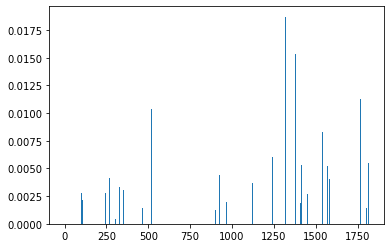

In [4]:
plt.bar(range(len(importances)), importances)

In [5]:
importances.max()

0.018715903

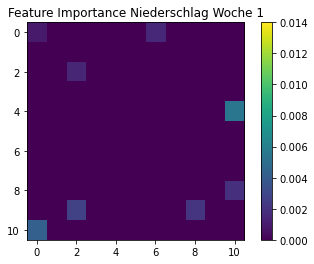

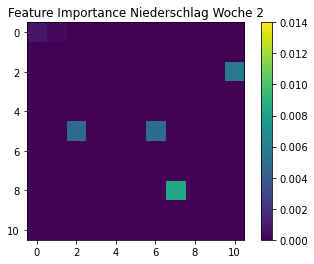

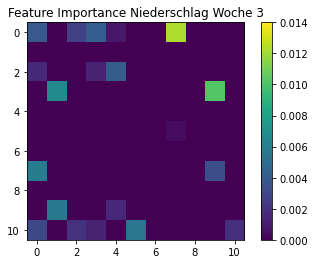

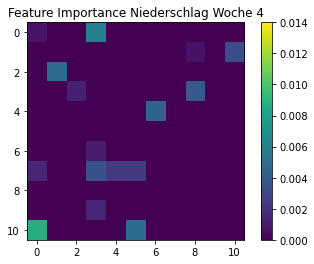

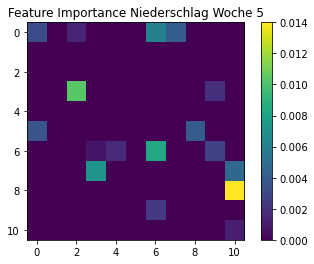

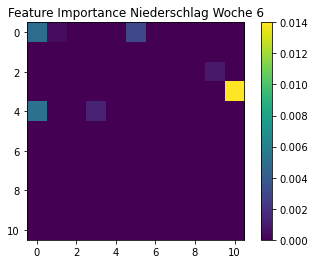

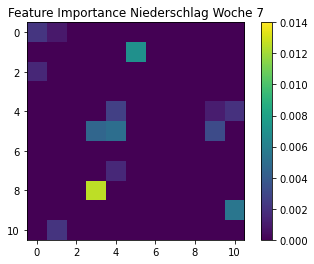

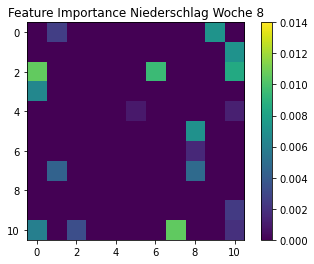

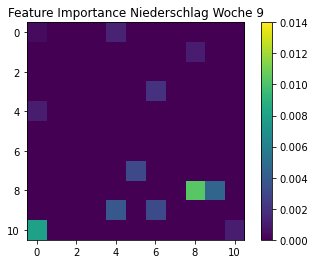

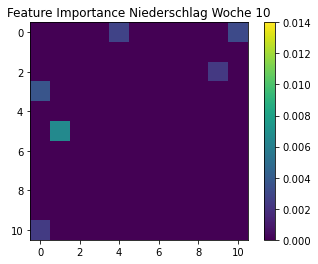

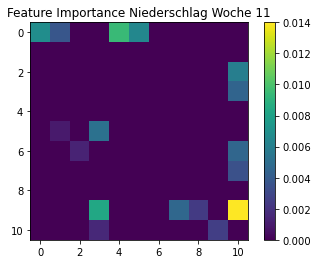

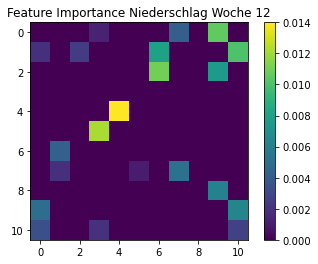

In [6]:
for i in range(12):
    plt.title('Feature Importance Niederschlag Woche '+str(i+1))
    plt.imshow(importances[i*121:(i+1)*121].reshape((11,11)), vmin=0, vmax=0.014)
    plt.colorbar()
    plt.show()

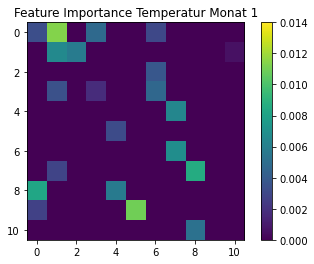

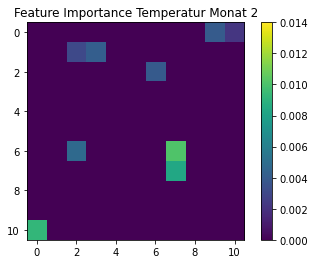

In [7]:
for i in range(3):
    plt.title('Feature Importance Temperatur Monat '+str(i+1))
    plt.imshow(importances[(i+12)*121:(i+13)*121].reshape((11,11)), vmin=0, vmax=0.014)
    plt.colorbar()
    plt.show()

In [8]:
print('Feature Importance Messtand 1: '+ str(importances[1815]))
print('Feature Importance Messtand 2: '+ str(importances[1816]))
print('Feature Importance Messtand 3: '+ str(importances[1817]))

Feature Importance Messtand 1: 0.0054792063
Feature Importance Messtand 2: 0.004617979
Feature Importance Messtand 3: 0.009208348


## 3. Evaluation

In [10]:
pred = np.load(data_drive +r'GruV-Net/data/model_eval/xgboost/xgboost_single_station_prc_temp_eval_preds_20201122-154047.npy')[4]
true = np.load(data_drive +r'GruV-Net/data/model_eval/xgboost/xgboost_single_station_prc_temp_eval_trues_20201122-154047.npy')[4]

ae = np.abs(pred - true)

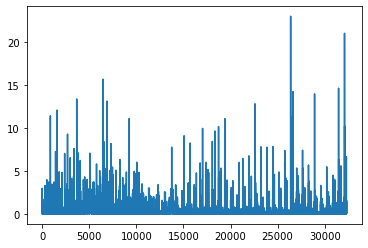

In [11]:
plt.plot(ae)

In [12]:
worst_instances = (-ae).argsort()[:20]
worst_instances

array([26382, 32102,  6478, 31471, 26640, 28922,  3668,  6875, 22594,
        1576,   869, 26395, 19394,  9235, 32115, 18727, 32163, 17031,
       18338,  2691], dtype=int64)